In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sns

# Load Data

In [3]:
df = pd.read_csv("/content/drive/MyDrive/bbc.csv")
print(df.head())

   Unnamed: 0                                               news      type
0           0  UK economy facing 'major risks'\n \n The UK ma...  business
1           1  Aids and climate top Davos agenda\n \n Climate...  business
2           2  Asian quake hits European shares\n \n Shares i...  business
3           3  India power shares jump on debut\n \n Shares i...  business
4           4  Lacroix label bought by US firm\n \n Luxury go...  business


In [4]:
df['category_id'] = df['type'].factorize()[0]

In [5]:
colslist = ['index', 'news', 'type', 'category_id']
df.columns = colslist

print(df.head())


   index                                               news      type  \
0      0  UK economy facing 'major risks'\n \n The UK ma...  business   
1      1  Aids and climate top Davos agenda\n \n Climate...  business   
2      2  Asian quake hits European shares\n \n Shares i...  business   
3      3  India power shares jump on debut\n \n Shares i...  business   
4      4  Lacroix label bought by US firm\n \n Luxury go...  business   

   category_id  
0            0  
1            0  
2            0  
3            0  
4            0  


# EDA

## Simple Analysis

<Axes: >

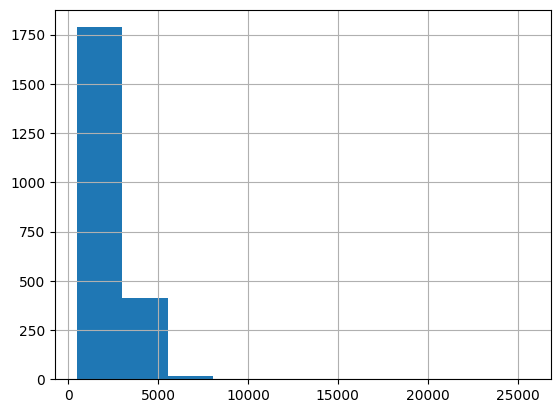

In [6]:
# num of characters/news
df['news'].str.len().hist()

<Axes: >

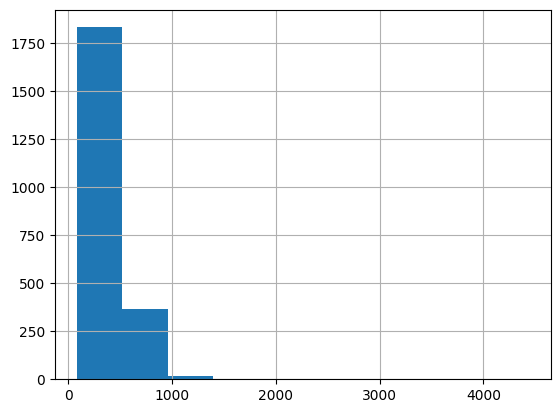

In [7]:
# num word /news
df["news"].str.split().map(lambda x: len(x)).hist()

<Axes: xlabel='type'>

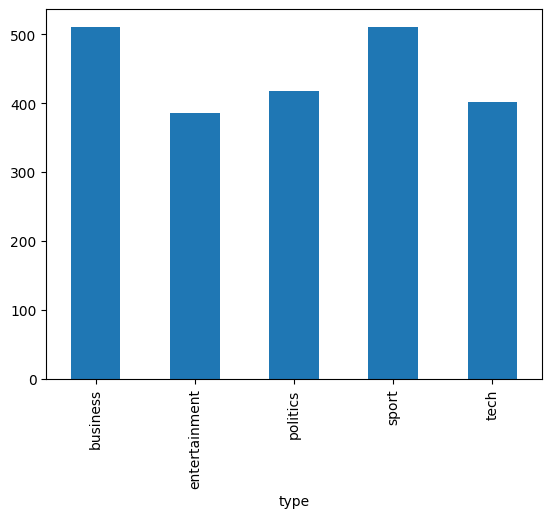

In [8]:
df.groupby('type').index.count().plot.bar(ylim=0)

## Word Analysis

In [9]:
# create a string for each cat
tech = ' '.join(list(df.news[df.type == 'tech']))
business = ' '.join(list(df.news[df.type == 'business']))
sport = ' '.join(list(df.news[df.type == 'sport']))
entertainment = ' '.join(list(df.news[df.type == 'entertainment']))
politics = ' '.join(list(df.news[df.type == 'politics']))

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [11]:
from wordcloud import WordCloud

def wordcloud(text, title):
    wordcloud = WordCloud(
        width = 1600,
        height = 1000,
        background_color = "white",
        stopwords = stop_words,
        min_font_size = 10
    ).generate(text)

    plt.figure(figsize = (16, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.title("Word Cloud for " + title + " Articles\n", fontsize = 20)
    plt.axis("off")
    plt.show()

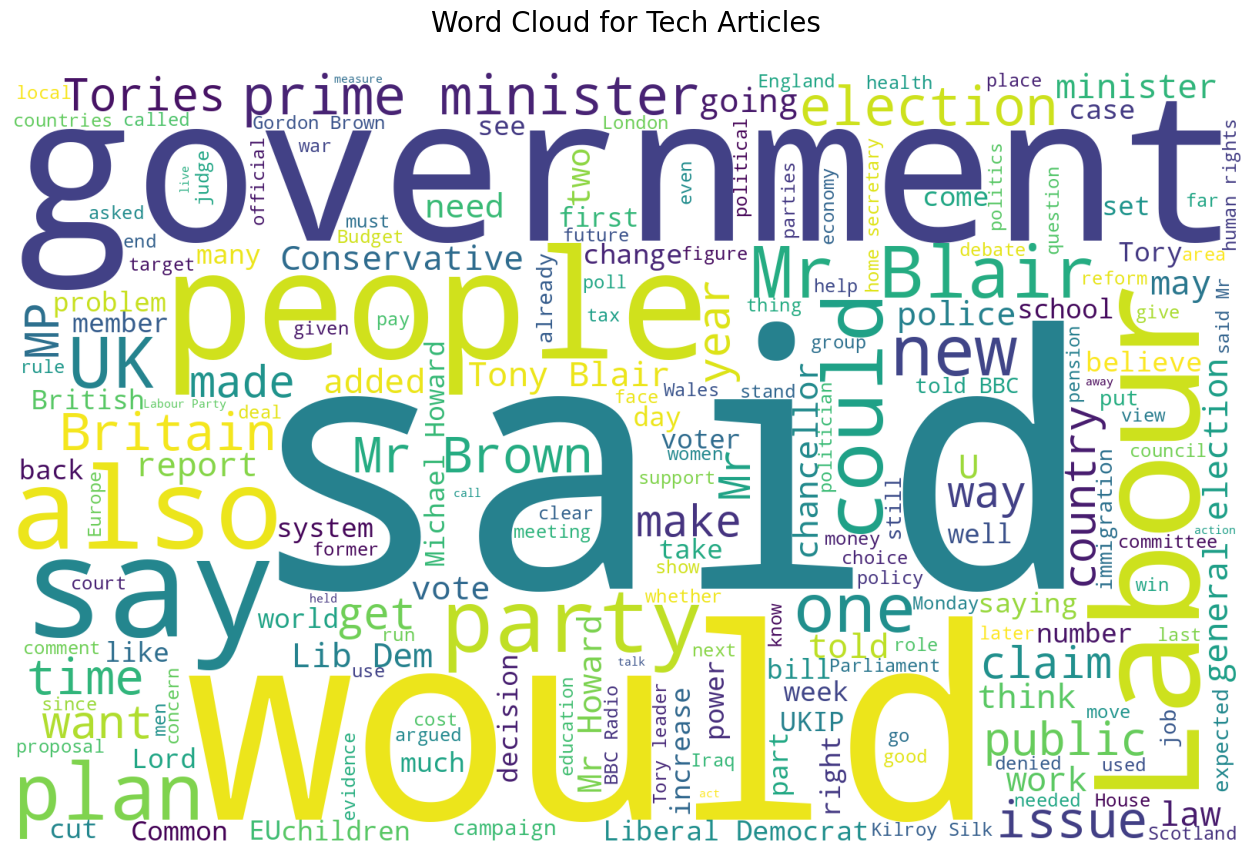

'\nThe word "said" is very frequent in each of the articles In fact it is most frequent in almost every category of article.\nFor tech related articles, the words like *people, technology, computer, software* are frequent.\nFor business related articles, the words like *market, growth, company, firm* are frequent.\nFor sport related articles, the words like *game, match, player, team, win* are frequent.\nFor entertainment related articles, the words like *film, show, music, award, band* are frequent.\nFor politics related articles, the words like *people, plan, labour, government* are frequent.\n'

In [17]:
 wordcloud(politics, "Tech")
"""
The word "said" is very frequent in each of the articles In fact it is most frequent in almost every category of article.
For tech related articles, the words like *people, technology, computer, software* are frequent.
For business related articles, the words like *market, growth, company, firm* are frequent.
For sport related articles, the words like *game, match, player, team, win* are frequent.
For entertainment related articles, the words like *film, show, music, award, band* are frequent.
For politics related articles, the words like *people, plan, labour, government* are frequent.
"""

# Prepare the Data

In [18]:
from nltk.stem import WordNetLemmatizer
import string
import nltk

stop_words = nltk.corpus.stopwords.words('english')
porter = PorterStemmer()

In [19]:
def preprocess(text):
    lemmas = []
    text = text.lower()
    text_punct = "".join([char for char in text if char not in string.punctuation])

    words = word_tokenize(text_punct)

    filtered_words = [word for word in words if word not in stop_words]

    stemmed = [porter.stem(word) for word in filtered_words]
    stemmed = ' '.join(stemmed)

    return stemmed

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
df['clean_text'] = df['news'].apply(preprocess)
print(df.shape)

(2225, 5)


# TF-IDF Vectorization

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
# sublinear_tf scaling is applied to reduce the effect of very frequent terms in the document
# norm l2: sum of the squares of the vector elements is 1
# Normalization can also help to reduce the impact of very long documents, which may have a higher term frequency than shorter documents.
# By applying normalization, the importance of each term in the document can be more accurately represented by the tf-idf weighting.
tfidf = TfidfVectorizer(sublinear_tf=True, max_features=200, norm='l2', ngram_range=(1, 2))

In [32]:
# Create features and labels
X = tfidf.fit_transform(df.clean_text).toarray()
y = df.category_id
X.shape

(2225, 200)

In [33]:
# create dict with id and category
category_id_df = df[['type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'type']].values)


In [34]:
from sklearn.feature_selection import chi2

'''
It is computing the chi-squared (KAY SQUARED) statistic and p-value for each feature (word or n-gram) in the text data (X) and the target labels (y)
indicating whether the news belongs to that category or not.
It is sorting the features by their chi-squared values in ascending order and storing their names in an array.
It is filtering the feature names to get only the unigrams (single words) and bigrams (two-word phrases).
'''

# Chi squared measures relevance of features to target variable.


N = 4
for newstype, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(X, y == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(newstype))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    #print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))


# 'business':
  . Most correlated unigrams:
       . analyst
       . economi
       . growth
       . bank
# 'entertainment':
  . Most correlated unigrams:
       . music
       . star
       . award
       . film
# 'politics':
  . Most correlated unigrams:
       . parti
       . elect
       . tori
       . labour
# 'sport':
  . Most correlated unigrams:
       . club
       . player
       . game
       . win
# 'tech':
  . Most correlated unigrams:
       . digit
       . technolog
       . comput
       . user


In [35]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(X) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(X)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0, init='random', learning_rate=200).fit_transform(X[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

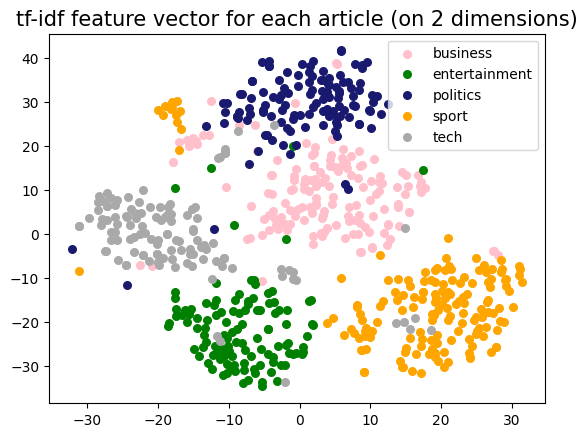

In [36]:
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(y[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)

plt.title("tf-idf feature vector for each article (on 2 dimensions)",
          fontdict=dict(fontsize=15))
plt.legend()

# Train Models

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [38]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    #SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
]

In [39]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

In [40]:
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [41]:
print(cv_df)

                model_name  fold_idx  accuracy
0   RandomForestClassifier         0  0.871910
1   RandomForestClassifier         1  0.829213
2   RandomForestClassifier         2  0.835955
3   RandomForestClassifier         3  0.838202
4   RandomForestClassifier         4  0.849438
5            MultinomialNB         0  0.939326
6            MultinomialNB         1  0.939326
7            MultinomialNB         2  0.928090
8            MultinomialNB         3  0.939326
9            MultinomialNB         4  0.937079
10      LogisticRegression         0  0.948315
11      LogisticRegression         1  0.955056
12      LogisticRegression         2  0.952809
13      LogisticRegression         3  0.948315
14      LogisticRegression         4  0.946067


<Axes: xlabel='model_name', ylabel='accuracy'>

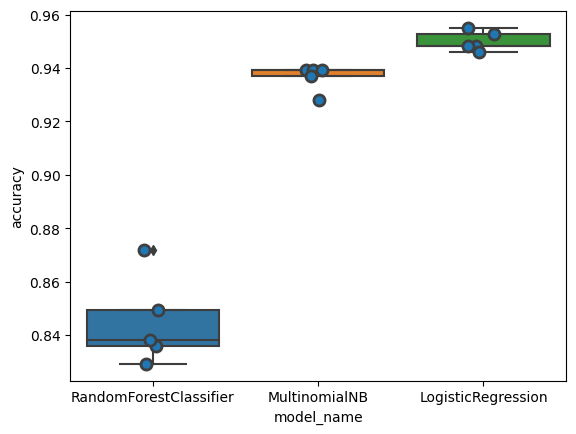

In [42]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,size=8, jitter=True, edgecolor="gray", linewidth=2)

In [43]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

Text(0.5, 23.52222222222222, 'Predicted')

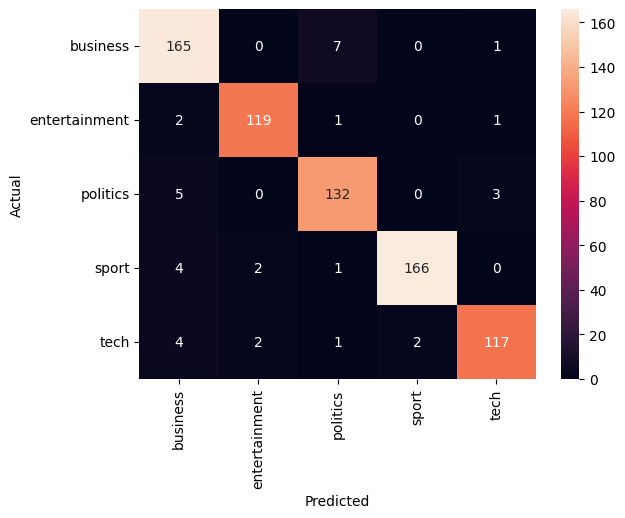

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
#print(conf_mat)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.type.values, yticklabels=category_id_df.type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [45]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "You won't guess what the latest trend in data analysis is!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_category[predicted]))
    print("")

"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'business'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'business'

"You won't guess what the latest trend in data analysis is!"
  - Predicted as: 'sport'

